## SD - 210 : Arbres de classification

In [1]:
# A few tactical imports
import pip 
pip.main(["install", "graphviz"])

import numpy as np
from numpy import random 
from numpy import linalg

import sklearn
from sklearn import preprocessing
from sklearn import tree
from sklearn import datasets
from sklearn import cross_validation

from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from math import fmod
import seaborn as sns
import graphviz# as graphviz
%matplotlib inline

sns.set(color_codes=True)
pylab.rcParams['figure.figsize'] = (15, 10)

You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


NameError: name 'pylab' is not defined

1) Dans le cadre de la régression, on peut prendre comme mesure d'homogénéité l'erreur quadratique moyenne : 

$ H(D_{n}) = \frac{1}{|D_{n}|}.\sum_{(x_{i}, y_{i}) \in D_{n}} (y_{i} - \bar{y_{n}})^{2}$ avec $\bar{y_{n}} = \frac{1}{|D_{n}|}.\sum_{(x_{i}, y_{i}) \in D_{n}} y_{i}$

Régulièrement employée pour mesurer la précision d'un estimateur, cette fonction à l'avantage de se décomposer comme la somme du carrée du biais et de la variance. Pour un arbre de régression, le biais étant généralement petit devant la variance, on a : 


$ H(D_{n}) \simeq V(D_{n})$

2)

In [296]:
from math import fmod
collist = ['blue', 'grey', 'red', 'purple', 'orange', 'salmon', 'black',
           'fuchsia']

def rand_checkers(n1=100, n2=100, n3=100, n4=100, sigma=0.1):
    """ Sample n1 and n2 points from a noisy checker"""
    nb1 = n1 // 8
    nb2 = n2 // 8
    nb3 = n3 // 8
    nb4 = n4 // 8

    xapp = np.reshape(np.zeros((nb1 + nb2 + nb3 + nb4) * 16),
                      [(nb1 + nb2 + nb3 + nb4) * 8, 2])
    yapp = np.ones((nb1 + nb2 + nb3 + nb4) * 8)
    idx = 0
    nb = 2 * nb1
    for i in range(-2, 2):
        for j in range(-2, 2):
            yapp[idx:(idx + nb)] = [fmod(i - j + 100, 4)] * nb
            xapp[idx:(idx + nb), 0] = np.random.rand(nb)
            xapp[idx:(idx + nb), 0] += i + sigma * np.random.randn(nb)
            xapp[idx:(idx + nb), 1] = np.random.rand(nb)
            xapp[idx:(idx + nb), 1] += j + sigma * np.random.randn(nb)
            idx += nb

    ind = np.arange((nb1 + nb2 + nb3 + nb4) * 8)
    np.random.shuffle(ind)
    res = np.hstack([xapp, yapp[:, np.newaxis]])
    return np.array(res[ind, :])

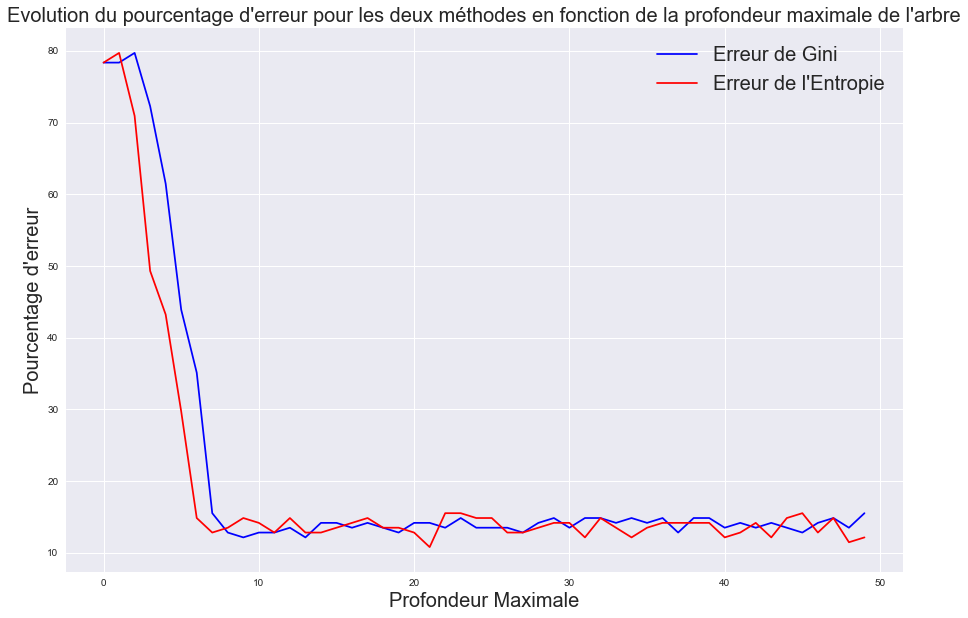

La meilleur profondeur de l'arbre est 21 .


In [314]:
n1, n2, n3, n4 = 114, 114, 114, 114  
data = rand_checkers(n1, n2, n3, n4, 0.1)

X = data[:, :2]
y = data[:, 2:3]

X_train,X_test,y_train,y_test = sklearn.model_selection.train_test_split(X,y,test_size=0.33)

Profondeur_max = 50
scoreGini = np.zeros(Profondeur_max)
scoreEntropie = np.zeros(Profondeur_max)

for i in range(Profondeur_max):
    dataGini = tree.DecisionTreeClassifier(max_depth=i+1)
    dataEntropie = tree.DecisionTreeClassifier(criterion='entropy',max_depth=i+1)
    dataGini.fit(X_train,y_train)
    dataEntropie.fit(X_train,y_train)
    scoreGini[i] = (1 - dataGini.score(X_test,y_test))*100
    scoreEntropie[i]= (1 - dataEntropie.score(X_test,y_test))*100

plt.plot(scoreGini, 'blue', label = 'Erreur de Gini')
plt.plot(scoreEntropie, 'red', label = "Erreur de l'Entropie")
plt.xlabel('Profondeur Maximale', fontsize = 20)
plt.ylabel("Pourcentage d'erreur", fontsize = 20)
plt.title("Evolution du pourcentage d'erreur pour les deux méthodes en fonction de la profondeur maximale de l'arbre", fontsize = 20)
plt.legend(fontsize = 20)
plt.show()

best_profondeur = np.argmin(scoreEntropie) 
print("La meilleur profondeur de l'arbre est", best_profondeur, ".")


3)

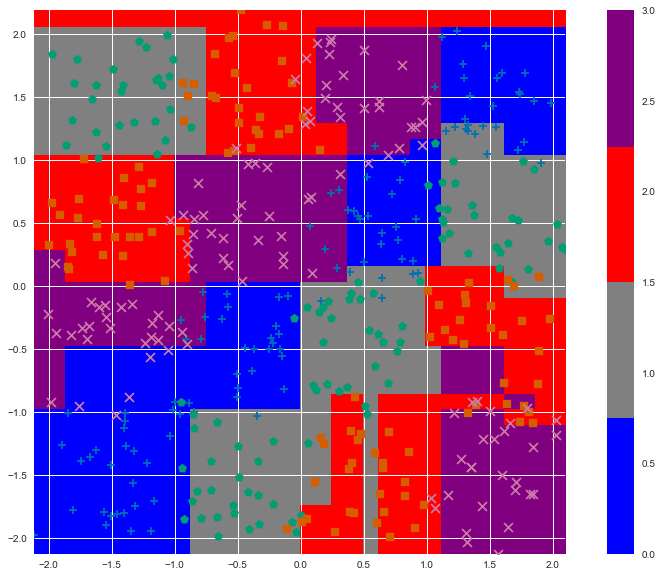

In [315]:
symlist = ['+', 'p', 's', 'x', 'o', '*', 'D', 'v', 'd', '^']


def plot_2d(data, y=None, w=None, alpha_choice=1):
    """ Plot in 2D the dataset data, colors and symbols according to the
    class given by the vector y (if given); the separating hyperplan w can
    also be displayed if asked"""

    k = np.unique(y).shape[0]
    color_blind_list = sns.color_palette("colorblind", k)
    sns.set_palette(color_blind_list)
    if y is None:
        labs = [""]
        idxbyclass = [range(data.shape[0])]
    else:
        labs = np.unique(y)
        idxbyclass = [np.where(y == labs[i])[0] for i in range(len(labs))]

    for i in range(len(labs)):
        plt.scatter(data[idxbyclass[i], 0], data[idxbyclass[i], 1],
                    c=color_blind_list[i], s=80, marker=symlist[i])
    plt.ylim([np.min(data[:, 1]), np.max(data[:, 1])])
    plt.xlim([np.min(data[:, 0]), np.max(data[:, 0])])
    mx = np.min(data[:, 0])
    maxx = np.max(data[:, 0])
    if w is not None:
        plt.plot([mx, maxx], [mx * -w[1] / w[2] - w[0] / w[2],
                              maxx * -w[1] / w[2] - w[0] / w[2]],
                 "g", alpha=alpha_choice)


def plot_2d_simple(data, y=None):
    if y is None:
        plt.scatter(data[:, 0], data[:, 1], s=50)
    else:
        nY = len(y)
        y = y.astype(int)
        Ycol = [collist[y[i] - 1 % len(collist)] for i in range(nY)]
        plt.scatter(data[:, 0], data[:, 1], c=Ycol, s=40)
        
def frontiere(f, data, step=50):
    """ trace la frontiere pour la fonction de decision f"""
    xmin, xmax = data[:, 0].min() - 1., data[:, 0].max() + 1.
    ymin, ymax = data[:, 1].min() - 1., data[:, 1].max() + 1.
    xx, yy = np.meshgrid(np.arange(xmin, xmax, (xmax - xmin) * 1. / step),
                         np.arange(ymin, ymax, (ymax - ymin) * 1. / step))
    z = f(np.c_[xx.ravel(), yy.ravel()])
    z = z.reshape(xx.shape)

    n_classes = np.unique(z).size
    cmap = ListedColormap(collist[:n_classes])
    plt.imshow(z, origin='lower', interpolation="nearest",
               extent=[xmin, xmax, ymin, ymax], cmap=cmap)

    plt.colorbar()
    
def f(x):
    """Classifier: needed to avoid warning due to shape issues"""
    return (dataEntropieErrorMin.predict(x))

dataEntropieErrorMin = tree.DecisionTreeClassifier(criterion='entropy',max_depth=best_profondeur)
clf = dataEntropieErrorMin.fit(X_train,y_train)

plot_2d(data, y)
frontiere(f, data)
plt.show()



4)

In [334]:
dot_data = tree.export_graphviz(clf, out_file = None) #nike ta race
graph = graphviz.Source(dot_data)
graph.render("tree-q4")

'tree-q4.pdf'

5)

In [316]:
n1bis = n2bis = n3bis = n4bis = 40
dataBis = rand_checkers(n1, n2, n3, n4, 0.1)
Xbis = dataBis[:, :2]
ybis = dataBis[:, 2:3]

scoreGinibis = np.zeros(Profondeur_max)
scoreEntropiebis = np.zeros(Profondeur_max)

print("Avant la génération du nouveau jeu de donnée, l'erreur minimale en pourcentage est de:", min(scoreGini), " % pour l'indice de Gini et de ", min(scoreEntropie),"% pour la mesure d'entropie.")

for i in range(Profondeur_max):
    scoreGinibis[i] = (1 - dataGini.score(Xbis,ybis))*100
    scoreEntropiebis[i]= (1 - dataEntropie.score(Xbis,ybis))*100

print("Après la génération du nouveau jeu de donnée, l'erreur minimale en pourcentage est maintenant de:", min(scoreGinibis)," % pour l'indice de Gini et de ", min(scoreEntropiebis), "% pour la mesure d'entropie.")
print("On observe le même résultat environ.")

Avant la génération du nouveau jeu de donnée, l'erreur minimale en pourcentage est de: 12.1621621622  % pour l'indice de Gini et de  10.8108108108 % pour la mesure d'entropie.
Après la génération du nouveau jeu de donnée, l'erreur minimale en pourcentage est maintenant de: 17.8571428571  % pour l'indice de Gini et de  17.4107142857 % pour la mesure d'entropie.
On observe le même résultat environ.


6)

In [1]:
digits = datasets.load_digits()
boston = datasets.load_boston()
diabetes = datasets.load_diabetes()
iris = datasets.load_iris()

NameError: name 'datasets' is not defined

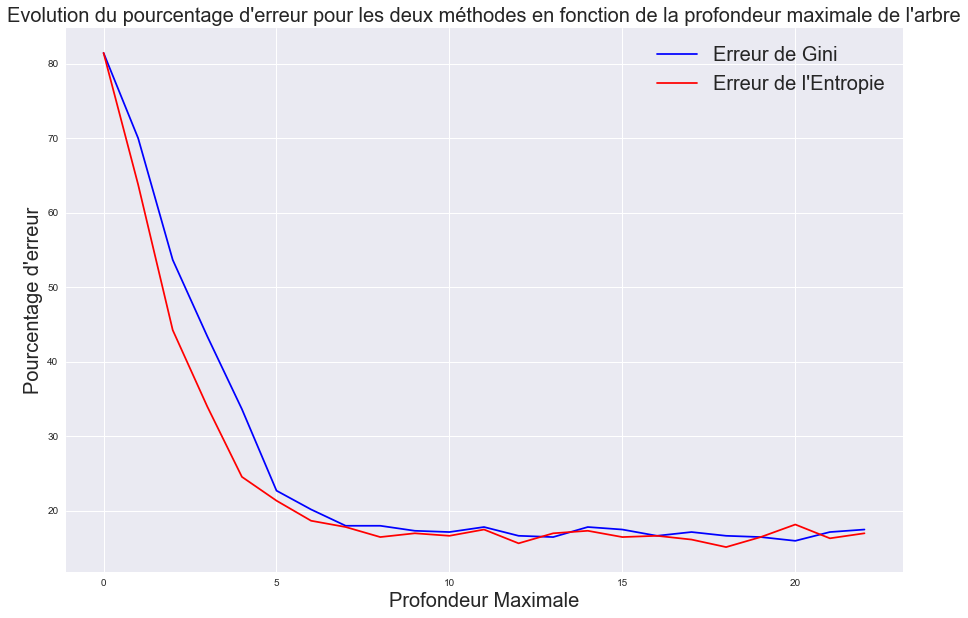

In [318]:
images_and_labels = list(zip(digits.images, digits.target))

n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

X = digits.data
y = digits.target

X_train,X_test,y_train,y_test = sklearn.model_selection.train_test_split(X,y,test_size=0.33)
Profondeur_max = 23
scoreGini = np.zeros(Profondeur_max)
scoreEntropie = np.zeros(Profondeur_max)

for i in range(Profondeur_max):
    dataGini = tree.DecisionTreeClassifier(max_depth=i+1)
    dataEntropie = tree.DecisionTreeClassifier(criterion='entropy',max_depth=i+1)
    dataGini.fit(X_train,y_train)
    dataEntropie.fit(X_train,y_train)
    scoreGini[i] = (1 - dataGini.score(X_test,y_test))*100
    scoreEntropie[i]= (1 - dataEntropie.score(X_test,y_test))*100

plt.plot(scoreGini, 'blue', label = 'Erreur de Gini')
plt.plot(scoreEntropie, 'red', label = "Erreur de l'Entropie")
plt.xlabel('Profondeur Maximale', fontsize = 20)
plt.ylabel("Pourcentage d'erreur", fontsize = 20)
plt.title("Evolution du pourcentage d'erreur pour les deux méthodes en fonction de la profondeur maximale de l'arbre", fontsize = 20)
plt.legend(fontsize = 20)
plt.show()

7)

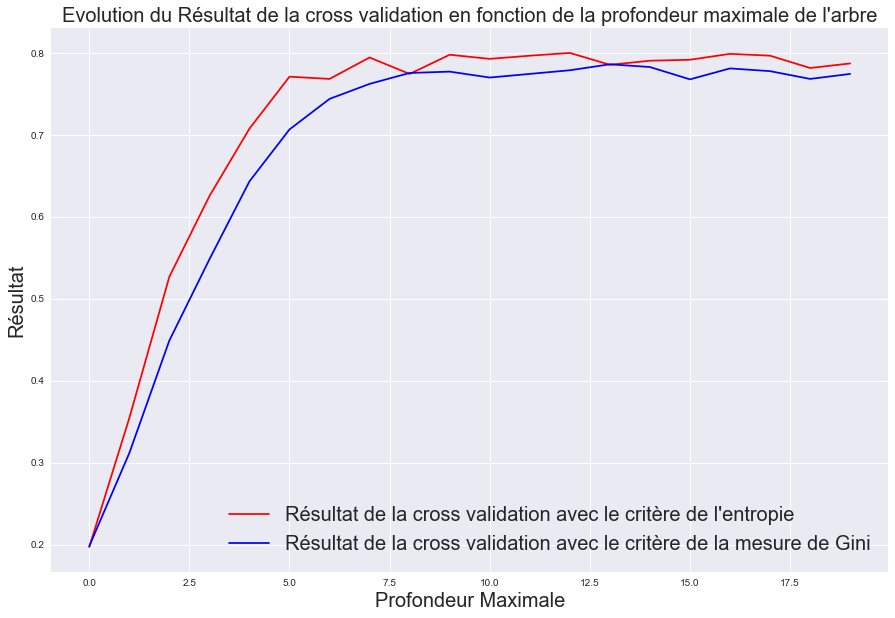

La meilleur profondeur de l'arbre est 12 .


In [320]:
ScoresEntropy = list()
ScoresGini = list()
for i in range (20):
    resultatEntropy = sklearn.cross_validation.cross_val_score(tree.DecisionTreeClassifier(criterion='entropy',max_depth=i+1), X,y)
    resultatGini = sklearn.cross_validation.cross_val_score(tree.DecisionTreeClassifier(max_depth=i+1), X,y)
    ScoresEntropy.append(np.mean(resultatEntropy))
    ScoresGini.append(np.mean(resultatGini))
    
plt.plot(ScoresEntropy, 'red', label ="Résultat de la cross validation avec le critère de l'entropie")
plt.plot(ScoresGini, 'blue', label ='Résultat de la cross validation avec le critère de la mesure de Gini')
plt.xlabel('Profondeur Maximale', fontsize = 20)
plt.ylabel("Résultat", fontsize = 20)
plt.title("Evolution du Résultat de la cross validation en fonction de la profondeur maximale de l'arbre", fontsize = 20)
plt.legend(loc = "best", fontsize = 20)
plt.show()


best_profondeur = np.argmax(ScoresEntropy) 
print("La meilleur profondeur de l'arbre est", best_profondeur, ".")



*Remarque* : On peut choisir la profondeur de l'arbre en prenant l'argmax de la courbe. 

8)

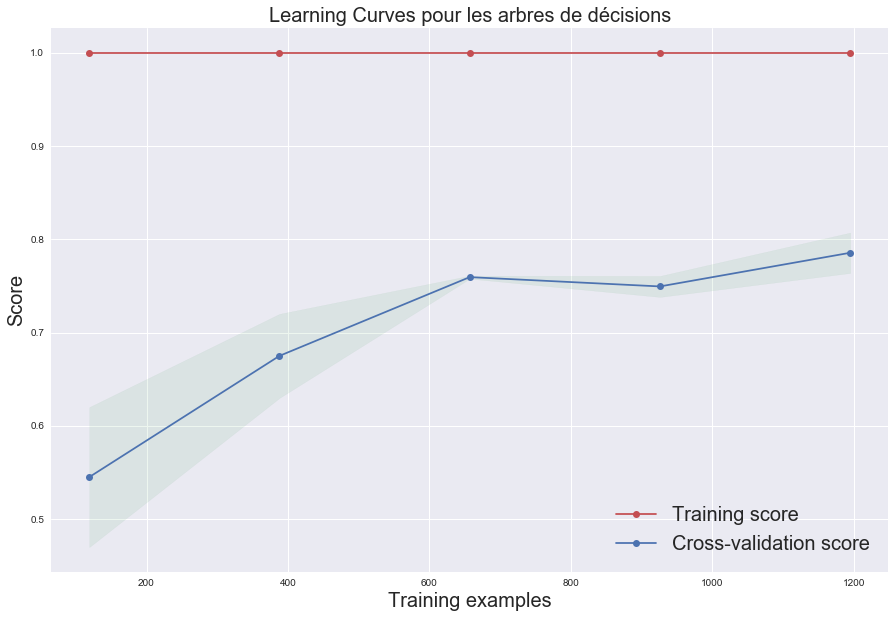

In [321]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title, fontsize = 20)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples", fontsize = 20)
    plt.ylabel("Score", fontsize = 20)
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=1, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="b",
             label="Cross-validation score")

    plt.legend(loc="lower right", fontsize = 20)
    plt.show()

plot_learning_curve(tree.DecisionTreeClassifier(criterion='entropy',max_depth=best_profondeur), 
                    "Learning Curves pour les arbres de décisions", X,y)